### 1. Daten

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
from torch.utils.data import Dataset
from txtReader import DataReader
from dataProcessing import lookup_symbol, add_time_information, create_one_hot_vector
from torch.utils.data import DataLoader
import pandas as pd
from config import config
import numpy as np
from perSymbolETFDataset import PerSymbolETFDataset


# Initialize the DataReader and read data
txt_reader = DataReader()
data = txt_reader.read_next_txt()

# Create a dataset from the read data
dataset = PerSymbolETFDataset(data, txt_reader.symbols)

# Create DataLoader for batch processing
dataloader = DataLoader(
    dataset, batch_size=1, shuffle=False  # Batch size set to 1 for individual stock processing
)

# Testen der Datenstruktur aus dem DataLoader
for batch in dataloader:
    src_data, tgt_data = batch
    print("Shape of src_data:", src_data.shape)
    print("First few rows of src_data:", src_data[:5])
    break  # Dies bricht die Schleife nach dem ersten Batch ab

def dataloader_to_dataframe(dataloader):
    frames = []
    for batch in dataloader:
        src_data, tgt_data = batch
        # nur den "close"-Kurs
        close_prices = src_data.numpy()[:, 1]  # Angenommene Position des "close"-Kurses
        frames.append(pd.DataFrame(close_prices, columns=['close']))
    return pd.concat(frames)

# DataLoader initialisieren und Daten in DataFrame umwandeln
stock_data = dataloader_to_dataframe(dataloader)

# ##### Daten auf Y-Achse Spiegeln

stock_data2 = stock_data.iloc[::-1].copy()

# ##### Gleitende Durchschnitte
stock_data2['5-day MA'] = stock_data2['close'].rolling(window=5).mean()
stock_data2['30-day MA'] = stock_data2['close'].rolling(window=30).mean()
stock_data2['200-day MA'] = stock_data2['close'].rolling(window=200).mean()

def compute_RSI(data, window=14):
    delta = data['close'].diff()

    # Verwenden von `loc` für bedingte Zuweisungen, um Probleme mit nicht eindeutiger Indizierung zu vermeiden
    loss = pd.Series(index=delta.index, dtype=float)
    gain = pd.Series(index=delta.index, dtype=float)

    loss.loc[delta < 0] = -delta[delta < 0]
    gain.loc[delta > 0] = delta[delta > 0]

    avg_loss = loss.rolling(window=window, min_periods=1).mean().abs()
    avg_gain = gain.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Behandeln Sie den Fall, bei dem avg_loss 0 ist, um Division durch Null zu vermeiden
    rsi[avg_loss == 0] = 100

    # Behandeln Sie den Fall, bei dem avg_gain 0 ist
    rsi[avg_gain == 0] = 0

    return rsi

# Berechnung des RSI für den DataFrame `stock_data2`
stock_data2['RSI'] = compute_RSI(stock_data2)


##### Daten aufbereiten

# Entfernen von NaN-Werten, die durch die rollenden Funktionen eingeführt wurden
stock_data2 = stock_data2.dropna()
stock_data2 = stock_data2.iloc[29:]  # Entfernt die ersten 29 Zeilen, die NaN-Werte wegen des 30-day MA haben könnten

stock_data2 = stock_data2.dropna()

# Aufteilen in Trainings- und Testdaten
train_size = int(0.7 * len(stock_data2))
train_data = stock_data2.iloc[:train_size]
test_data = stock_data2.iloc[train_size:]

#Data: close  5-day MA  30-day MA  200-day MA      RSI



                timestamp    open    high     low   close  volume symbol
0     2018-08-15 09:30:00  11.840  11.840  11.840  11.840    2800   AAAU
1     2018-08-15 09:37:00  11.830  11.830  11.830  11.830     500   AAAU
2     2018-08-15 09:38:00  11.830  11.830  11.830  11.830     300   AAAU
3     2018-08-15 09:41:00  11.820  11.820  11.820  11.820    1300   AAAU
4     2018-08-15 09:42:00  11.820  11.820  11.820  11.820     700   AAAU
...                   ...     ...     ...     ...     ...     ...    ...
61343 2021-03-12 15:55:00  17.165  17.168  17.165  17.168     200   AAAU
61344 2021-03-12 15:57:00  17.170  17.170  17.165  17.165    5582   AAAU
61345 2021-03-12 15:58:00  17.160  17.160  17.160  17.160     100   AAAU
61346 2021-03-12 15:59:00  17.160  17.160  17.155  17.160    9600   AAAU
61347 2021-03-12 16:00:00  17.160  17.160  17.160  17.160    4341   AAAU

[61348 rows x 7 columns]
Shape of src_data: torch.Size([1, 92])
First few rows of src_data: tensor([[1.1840e+01, 1.1840e+01

### 2. Einfache Trading-Umgebung

In [8]:
import numpy as np

class TradingEnvironment:

    def discretize_price(price, min_price, max_price, n_bins=100):
        bin_width = (max_price - min_price) / n_bins
        discrete_val = int((price - min_price) / bin_width)
        return min(discrete_val, n_bins - 1)  # Im Falle, dass der Preis genau dem max_price entspricht

    def __init__(self, data):
        if data.empty:
            raise ValueError("The provided data is empty!")
            
        self.data = data
        self.current_step = 0
        self.done = False
        self.balance = 1000  # angenommener Startguthaben
        self.stock_owned = 0  # keine Aktien zu Beginn

    def reset(self):
        self.current_step = 0
        self.done = False
        self.balance = 1000
        self.stock_owned = 0
        
        states = {
            'ma5': [self.discretize_price(self.data['5-day MA'].iloc[self.current_step]), self.discretize_price(self.data['close'].iloc[self.current_step])],
            'ma30': [self.discretize_price(self.data['30-day MA'].iloc[self.current_step]), self.discretize_price(self.data['close'].iloc[self.current_step])],
            'ma200': [self.discretize_price(self.data['200-day MA'].iloc[self.current_step]), self.discretize_price(self.data['close'].iloc[self.current_step])],
            'rsi': [int(self.data['RSI'].iloc[self.current_step] // 10), self.discretize_price(self.data['close'].iloc[self.current_step])]
        }
        
        return states


    def get_state(self, agent_type=None):
        if self.current_step >= len(self.data):
            raise Exception("Current step exceeds data length.")
        
        current_row = self.data.iloc[self.current_step]
        close_price_discrete = self.discretize_price(current_row['close'])

        if agent_type == 'ma5':
            ma5_discrete = self.discretize_price(current_row.get('5-day MA', 0))
            return [close_price_discrete, ma5_discrete]
        elif agent_type == 'ma30':
            ma30_discrete = self.discretize_price(current_row.get('30-day MA', 0))
            return [close_price_discrete, ma30_discrete]
        elif agent_type == 'ma200':
            ma200_discrete = self.discretize_price(current_row.get('200-day MA', 0))
            return [close_price_discrete, ma200_discrete]
        elif agent_type == 'rsi':
            rsi_discrete = int(current_row.get('RSI', 50) // 10)
            return [close_price_discrete, rsi_discrete]
        else:
            return [close_price_discrete]

    def discretize_price(self, price, min_price=0, max_price=1000, n_bins=100):
        return min(int((price - min_price) * n_bins / (max_price - min_price)), n_bins - 1)


    def step(self, action):
        if self.done:
            raise Exception("The episode is done. Reset the environment.")
    
        prev_balance = self.balance
        current_price = self.data['close'].iloc[self.current_step]
    
        if action == 0:  # Kaufen
            if self.stock_owned == 0:
                self.stock_owned = 1
                self.balance -= current_price
            else:
                reward = -10  # Strafe für ungültigen Kauf
        elif action == 2:  # Verkaufen
            if self.stock_owned == 1:
                self.stock_owned = 0
                self.balance += current_price
            else:
                reward = -10  # Strafe für ungültigen Verkauf
        elif action == 1:  # Halten
            reward = 0

    
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True
            return [], 0, True
    
        reward = self.balance - prev_balance

        trade_penalty = -10 #BEstrafung für zu viele Trades
        reward += trade_penalty

        next_states = {
            'ma5': [self.discretize_price(self.data['5-day MA'].iloc[self.current_step]), self.discretize_price(self.data['close'].iloc[self.current_step])],
            'ma30': [self.discretize_price(self.data['30-day MA'].iloc[self.current_step]), self.discretize_price(self.data['close'].iloc[self.current_step])],
            'ma200': [self.discretize_price(self.data['200-day MA'].iloc[self.current_step]), self.discretize_price(self.data['close'].iloc[self.current_step])],
            'rsi': [int(self.data['RSI'].iloc[self.current_step] // 10), self.discretize_price(self.data['close'].iloc[self.current_step])]
        }

        return next_states, reward, self.done



### 3.0 Aggregationsfunktion

In [11]:
def aggregate_actions(actions):
    """
    Nimmt eine Liste von Aktionen entgegen und gibt die am häufigsten vorgeschlagene Aktion zurück.
    """
    return max(set(actions), key=actions.count)
    
def aggregate_q_values(agents, states):
    combined_q_values = np.zeros(3)  # Angenommen, es gibt 3 Aktionen: Kaufen, Halten, Verkaufen
    for agent, agent_type in zip(agents, agent_types):
        state = states[agent_type]
        q_values = agent.get_q_values(state)
        combined_q_values += q_values
    return np.argmax(combined_q_values)


### 3.1 Einfacher Agent

In [5]:
class SimpleAgent:
    def __init__(self, agent_type='ma5'):
        self.agent_type = agent_type

    def act(self, state):
        close_price, indicator_value = state
        if self.agent_type == 'ma5':
            return 0 if close_price > indicator_value else 2  # 0: Kaufen, 2: Verkaufen
        elif self.agent_type == 'ma30':
            return 0 if close_price > indicator_value else 2
        elif self.agent_type == 'ma200':
            return 0 if close_price > indicator_value else 2
        elif self.agent_type == 'rsi':
            return 0 if indicator_value < 30 else 2 if indicator_value > 70 else 1  # 1: Halten

### 3.2 DQN

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Definieren des neuronalen Netzes für DQN
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# DQN-Agent
class DQNAgent:
    def __init__(self, state_size, action_size, agent_type, learning_rate=0.001, discount_factor=0.95, exploration_max=1.0, exploration_min=0.01, exploration_decay=0.995, batch_size=64, memory_size=2000, update_target_every=10):
        self.state_size = state_size
        self.action_size = action_size
        self.agent_type = agent_type 
        self.memory = deque(maxlen=memory_size)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.batch_size = batch_size
        self.update_target_every = update_target_every
        self.train_step_counter = 0
        
        # Hauptmodell
        self.model = DQNNetwork(state_size, action_size).float()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        
        # Zielmodell
        self.target_model = DQNNetwork(state_size, action_size).float()
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()  # Setzen Sie das Zielmodell in den Evaluierungsmodus

    def get_q_values(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state_tensor).detach().numpy()
        return q_values.squeeze()  # Dies wird die Form von (1, 3) zu (3,) ändern
        
    def extract_state(self, states, agent_type):
        return states[agent_type]

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Zufällige Minibatch aus dem Speicher
        batch = random.sample(self.memory, self.batch_size)
        state_batch = torch.FloatTensor([item[0] for item in batch])
        action_batch = torch.LongTensor([item[1] for item in batch]).unsqueeze(1)
        reward_batch = torch.FloatTensor([item[2] for item in batch]).unsqueeze(1)
        next_state_batch = torch.FloatTensor([item[3] for item in batch])
        done_batch = torch.BoolTensor([item[4] for item in batch])

        # Q-Werte für die aktuellen Zustände
        q_values = self.model(state_batch).gather(1, action_batch)
        
        # Q-Werte für die nächsten Zustände
        next_q_values = self.target_model(next_state_batch).detach().max(1)[0].unsqueeze(1)
        target_q_values = reward_batch + (self.discount_factor * next_q_values * (~done_batch))

        # Netzwerk aktualisieren
        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Exploration-Rate aktualisieren
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(self.exploration_min, self.exploration_rate)

        # Zielnetzwerk in regelmäßigen Abständen aktualisieren
        self.train_step_counter += 1
        if self.train_step_counter % self.update_target_every == 0:
            self.target_model.load_state_dict(self.model.state_dict())

# Agenteninitialisierung
dqn_ma5_agent = DQNAgent(state_size=2, action_size=3, agent_type='ma5')
dqn_ma30_agent = DQNAgent(state_size=2, action_size=3, agent_type='ma30')
dqn_ma200_agent = DQNAgent(state_size=2, action_size=3, agent_type='ma200')
dqn_rsi_agent = DQNAgent(state_size=2, action_size=3, agent_type='rsi')

# Agententraining
def train_dqn_agent(agent, environment, agent_type, num_episodes=100):
    for episode in range(num_episodes):
        total_reward = 0
        states = environment.reset()
        done = False
        
        while not done:
            state = agent.extract_state(states, agent_type)
            action = agent.act(state)
            next_states, reward, done = environment.step(action)
            next_state = agent.extract_state(next_states, agent_type)
            agent.remember(state, action, reward, next_state, done)
            agent.learn()
            
            states = next_states
            total_reward += reward

        print(f"Episode {episode+1}/{num_episodes} - Reward: {total_reward}")


dqn_agents = [dqn_ma5_agent, dqn_ma30_agent, dqn_ma200_agent, dqn_rsi_agent]




### 6. MARL

In [12]:
from tqdm import tqdm

env = TradingEnvironment(train_data)

# Erstellen Sie separate Agenten für verschiedene Indikatoren
ma5_agent = SimpleAgent(agent_type='ma5')
ma30_agent = SimpleAgent(agent_type='ma30')
ma200_agent = SimpleAgent(agent_type='ma200')
rsi_agent = SimpleAgent(agent_type='rsi')

agents = [ma5_agent, ma30_agent, ma200_agent, rsi_agent]
agent_types = ['ma5', 'ma30', 'ma200', 'rsi']

# Trainieren Sie die Agenten
NUM_EPISODES = 10

for episode in tqdm(range(NUM_EPISODES)):
    states = env.reset()
    done = False

    while not done:
        # Verwenden Sie die aggregierten Q-Werte, um eine Entscheidung zu treffen
        final_action = aggregate_q_values(dqn_agents, states)
        
        next_states, reward, done = env.step(final_action)

        if not done:
            for agent in dqn_agents:
                agent_type = agent.agent_type
                agent.remember(states[agent_type], final_action, reward, next_states[agent_type], done)
                agent.learn()

        states = next_states


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Joel\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 30%|███       | 3/10 [1:38:26<3:38:49, 1875.66s/it]

### Agenten testen vs Buy and Hold

In [ ]:
# Setzen Sie die exploration_rate für alle Agenten auf 0
for agent in agents:
    agent.exploration_rate = 0

# Initialisieren Sie die Testumgebung
env_test = TradingEnvironment(test_data)
states = env_test.reset()



initial_balance = env_test.balance
done = False

def combine_actions(actions):
    """
    Nimmt eine Liste von Aktionen entgegen und gibt die am häufigsten vorgeschlagene Aktion zurück.
    """
    return max(set(actions), key=actions.count)

while not done:
    # Lassen Sie jeden Agenten eine Aktion basierend auf dem aktuellen Zustand auswählen
    actions = [agent.act(states[agent_type]) for agent, agent_type in zip(agents, agent_types)]
    
    # Kombinieren Sie die Aktionen der Agenten zu einer endgültigen Aktion
    final_action = combine_actions(actions)
    
    # Aktualisieren Sie die Umgebung mit der endgültigen Aktion
    next_states, _, done = env_test.step(final_action)
    states = next_states

# Berechnen Sie den erzielten Gewinn
profit = env_test.balance - initial_balance

# Berechnen Sie den "Buy and Hold"-Gewinn
buy_and_hold_profit = test_data['close'].iloc[-1] - test_data['close'].iloc[0]

print(f"Profit on the test set with multi-agent trading: ${profit:.2f}")
print(f"Profit on the test set with 'Buy and Hold': ${buy_and_hold_profit:.2f}")

Profit on the test set with multi-agent trading: $74.85
Profit on the test set with 'Buy and Hold': $65.19


### 5. Visualisierung

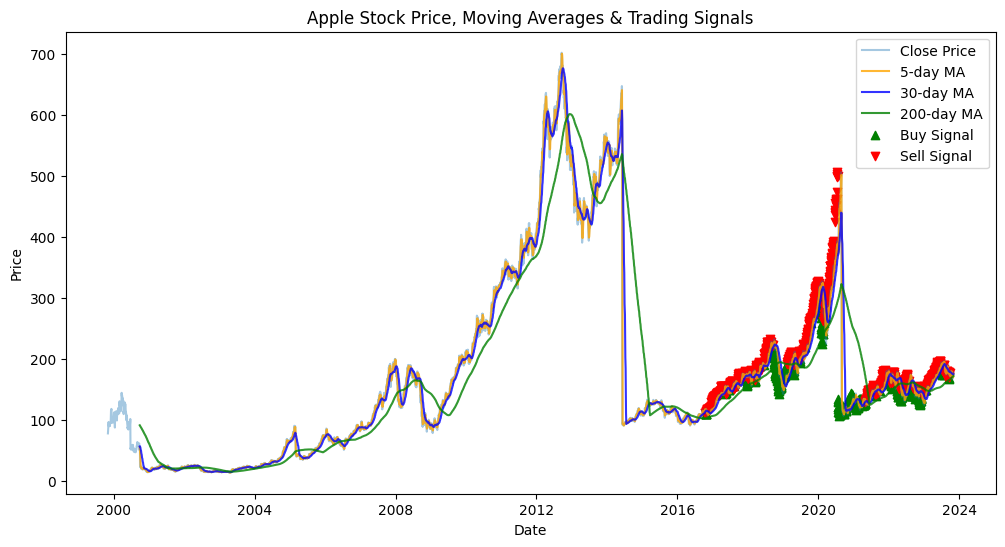

In [ ]:
import matplotlib.pyplot as plt

# Daten umkehren, sodass der älteste Handelstag zuerst erscheint
stock_data = stock_data.iloc[::-1]

# Umgebung initialisieren
env = TradingEnvironment(test_data)

# Handel ausführen und Entscheidungen speichern
buy_points = []
sell_points = []

states = env.reset()
done = False

while not done:
    # Jeder Agent trifft eine Entscheidung
    actions = [agent.act(states[agent_type]) for agent, agent_type in zip(agents, agent_types)]
    
    # Aggregieren Sie die Entscheidungen (z.B. nehmen Sie die häufigste Aktion)
    final_action = np.argmax(np.bincount(actions))

    offset = len(train_data) + 199  # 199 ist die Anzahl der unberücksichtigten Datenpunkte durch den 200-Tage MA
    
    if final_action == 0:  # Kaufentscheidung
        buy_points.append((env.current_step + offset, env.data['close'].iloc[env.current_step]))

    elif final_action == 2:  # Verkaufsentscheidung
        sell_points.append((env.current_step + offset, env.data['close'].iloc[env.current_step]))

    next_states, reward, done = env.step(final_action)
    states = next_states


# Visualisierung
plt.figure(figsize=(12,6))
plt.plot(stock_data['close'], label='Close Price', alpha=0.4)

# Hinzufügen der MA-Linien
plt.plot(stock_data2['5-day MA'], label='5-day MA', color='orange', alpha=0.8)
plt.plot(stock_data2['30-day MA'], label='30-day MA', color='blue', alpha=0.8)
plt.plot(stock_data2['200-day MA'], label='200-day MA', color='green', alpha=0.8)

index_list = stock_data.index.to_list()  # Konvertieren des DataFrame-Indexes in eine Liste

buy_x, buy_y = zip(*buy_points)
buy_dates = [index_list[x] for x in buy_x]  # Extrahieren der tatsächlichen Datumsangaben für Kaufaktionen

sell_x, sell_y = zip(*sell_points)
sell_dates = [index_list[x] for x in sell_x]  # Extrahieren der tatsächlichen Datumsangaben für Verkaufsaktionen

plt.scatter(buy_dates, buy_y, marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(sell_dates, sell_y, marker='v', color='r', label='Sell Signal', alpha=1)
plt.title('Apple Stock Price, Moving Averages & Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
